# Neural Nets for jet images

Notebook for training and evaluating neural network taggers using jet images.

This example is about separating jets (collimated sprays of hadronic particles) using an "imaging" technique based on a convolutional neural network. SignaL jets are from hadronic decays of W bosons, while background jets are produced from the hadronisation of light quarks, or gluons. The jets are measured in the detector calorimeter, where they leave their energy. The images are the transverse energies deposited by a jet in the calorimeter cells, with each image being centred on the jet axis, and the weight of each cell is the transverse energy deposited. Jets from background tend to have most of the transverse enrgy deposited in the centre, while those from BG, that are actually composed of two very nearby jets, present rather a two-prong structure, and the network should be able to distinguish the two cases.
Write a concolutional neural network to distinguish the teo classes, train it, and evaluate its performance.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
%cd "/content/gdrive/MyDrive/Physics-Classification-Project"

/content/gdrive/MyDrive/Physics-Classification-Project


### Import everything

In [3]:
from __future__ import division, print_function
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib

In [4]:
#Some configuration for GPU machines, may not be necessary
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.compat.v1.Session(config=config)

### Neural Network configuration

In [5]:
np.random.seed(94)
loss_function = 'categorical_crossentropy'
vector_length = 40 * 40
optimizer = 'adam'
nb_epochs = 10
multi_gpu_training = False

nb_top_lund_planes = 10000
nb_QCD_lund_planes = 10000
nb_W_lund_planes = 10000
model_name = 'CNN'

do_shuffle = True
save_trained_model = False
test_sample_size = 0.25

#NB: Change input_filename to location of dataset on your system.
input_filename = "/content/gdrive/MyDrive/Physics-Classification-Project/data/20190920_pt600.0_1500.0_40bins_10k.npz"

In [6]:
infile = np.load(input_filename)
for each in infile:
    print(each)

QCD_jet_images
QCD_prim_lund_planes
QCD_sec_lund_planes
QCD_lund_planes
QCD_prim_lund_z_values
QCD_prim_lund_kt_values
QCD_prim_lund_dr_values
QCD_sec_lund_z_values
QCD_sec_lund_kt_values
QCD_sec_lund_dr_values
top_jet_images
top_prim_lund_planes
top_sec_lund_planes
top_lund_planes
top_prim_lund_z_values
top_prim_lund_kt_values
top_prim_lund_dr_values
top_sec_lund_z_values
top_sec_lund_kt_values
top_sec_lund_dr_values
W_jet_images
W_prim_lund_planes
W_sec_lund_planes
W_lund_planes
W_prim_lund_z_values
W_prim_lund_kt_values
W_prim_lund_dr_values
W_sec_lund_z_values
W_sec_lund_kt_values
W_sec_lund_dr_values


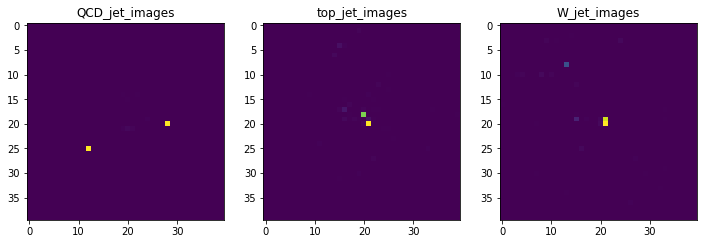

In [7]:
n=-1
fig, axes = plt.subplots(1,3,figsize=(12,10))
axes[0].set_title('QCD_jet_images')
axes[0].imshow(infile['QCD_jet_images'][n])
axes[1].set_title('top_jet_images')
axes[1].imshow(infile['top_jet_images'][n])
axes[2].set_title('W_jet_images')
axes[2].imshow(infile['W_jet_images'][n])
plt.show()

In [8]:
infile = np.load(input_filename)

outfile = {}

for key in infile.keys():
    outfile[key] = infile[key][:10000]
    print(key)

np.savez_compressed(input_filename,**outfile)

QCD_jet_images
QCD_prim_lund_planes
QCD_sec_lund_planes
QCD_lund_planes
QCD_prim_lund_z_values
QCD_prim_lund_kt_values
QCD_prim_lund_dr_values
QCD_sec_lund_z_values
QCD_sec_lund_kt_values
QCD_sec_lund_dr_values
top_jet_images
top_prim_lund_planes
top_sec_lund_planes
top_lund_planes
top_prim_lund_z_values
top_prim_lund_kt_values
top_prim_lund_dr_values
top_sec_lund_z_values
top_sec_lund_kt_values
top_sec_lund_dr_values
W_jet_images
W_prim_lund_planes
W_sec_lund_planes
W_lund_planes
W_prim_lund_z_values
W_prim_lund_kt_values
W_prim_lund_dr_values
W_sec_lund_z_values
W_sec_lund_kt_values
W_sec_lund_dr_values


In [9]:
print(np.shape(infile['QCD_prim_lund_planes']))
print(np.shape(outfile['QCD_prim_lund_planes']))

(10000, 40, 40)
(10000, 40, 40)


### Loading pre-processing data 

In [10]:
print("loading {} feature vector dataset...".format(vector_length))

input_data = np.load(input_filename)

top_samples = input_data['top_jet_images'][:nb_top_lund_planes]
w_samples = input_data['W_jet_images'][:nb_W_lund_planes]
qcd_samples = input_data['QCD_jet_images'][:nb_QCD_lund_planes]

X_BG = qcd_samples
X_S1 = top_samples
X_S2 = w_samples

print("S1 samples:", len(X_S1))
print("S2 samples:", len(X_S2))
print("BG samples:", len(X_BG))

print("ratio S1/BG:", len(X_S1) / len(X_BG))
print("ratio S2/BG:", len(X_S2) / len(X_BG))

np.random.shuffle(X_BG)

#Label data
y_S1 = np.ones(len(X_S1))
y_S2 = np.ones(len(X_S2)) + 1
y_BG = np.zeros(len(X_BG)) 

X = np.append(X_S1, X_S2, axis=0)
X = np.append(X, X_BG, axis=0)
y = np.append(y_S1, y_S2, axis=0)
y = np.append(y, y_BG, axis=0)
print(np.shape(X),np.shape(y))

# CNN architecture is built to take color images. 
# Therefore, input shape is: 1 colour channel + 1 imagege channel (flattened)
X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1) )

# Split data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, shuffle=True)
print('X_train',np.shape(X_train),
      'X_test',X_test.shape,
      'y_train',y_train.shape,
      'y_test',y_test.shape)

# Reshape target vectors
y = to_categorical(y, 3)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print('y_train',y_train.shape,'y_test',y_test.shape)

input_shape = X[0].shape
print("Input vector shape:", input_shape)
print("Number of input samples:", len(X))

loading 1600 feature vector dataset...
S1 samples: 10000
S2 samples: 10000
BG samples: 10000
ratio S1/BG: 1.0
ratio S2/BG: 1.0
(30000, 40, 40) (30000,)
X_train (27000, 40, 40, 1) X_test (3000, 40, 40, 1) y_train (27000,) y_test (3000,)
y_train (27000, 3) y_test (3000, 3)
Input vector shape: (40, 40, 1)
Number of input samples: 30000


In [11]:
print(y_test[:10])

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


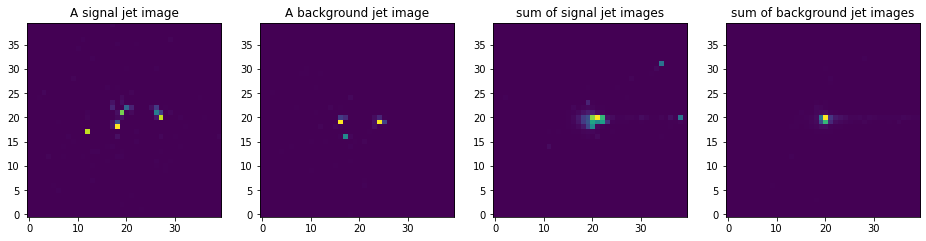

In [12]:
iimg_sig = np.random.randint(0,len(X_S1))
iimg_bkg = np.random.randint(0,len(X_BG))

fig, axes = plt.subplots(1,4,figsize=(16,10))
axes[0].set_title("A signal jet image")
axes[0].imshow(X_S1[iimg_sig].reshape(X_S1.shape[1], X_S1.shape[2]), origin="lower")
axes[1].set_title("A background jet image")
axes[1].imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
axes[2].set_title("sum of signal jet images")
axes[2].imshow(np.sum(X_S2, axis=0).reshape(X_S1.shape[1], X_S1.shape[2]), origin="lower")
axes[3].set_title("sum of background jet images")
axes[3].imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.show()

### Training

In [13]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):

    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

    def get_config(self):
      base_config = super(Attention, self).get_config().copy()
      base_config.update({
            'return_sequences': self.return_sequences,
            })
      return base_config

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(keras.layers.AveragePooling2D((2, 2)))
model.add(Attention(return_sequences=True))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.AveragePooling2D((2, 2)))
model.add(Attention(return_sequences=True))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 19, 19, 32)        0         
_________________________________________________________________
attention (Attention)        (None, 19, 19, 32)        51        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 32)          0         
_________________________________________________________________
attention_1 (Attention)      (None, 8, 8, 32)          40        
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

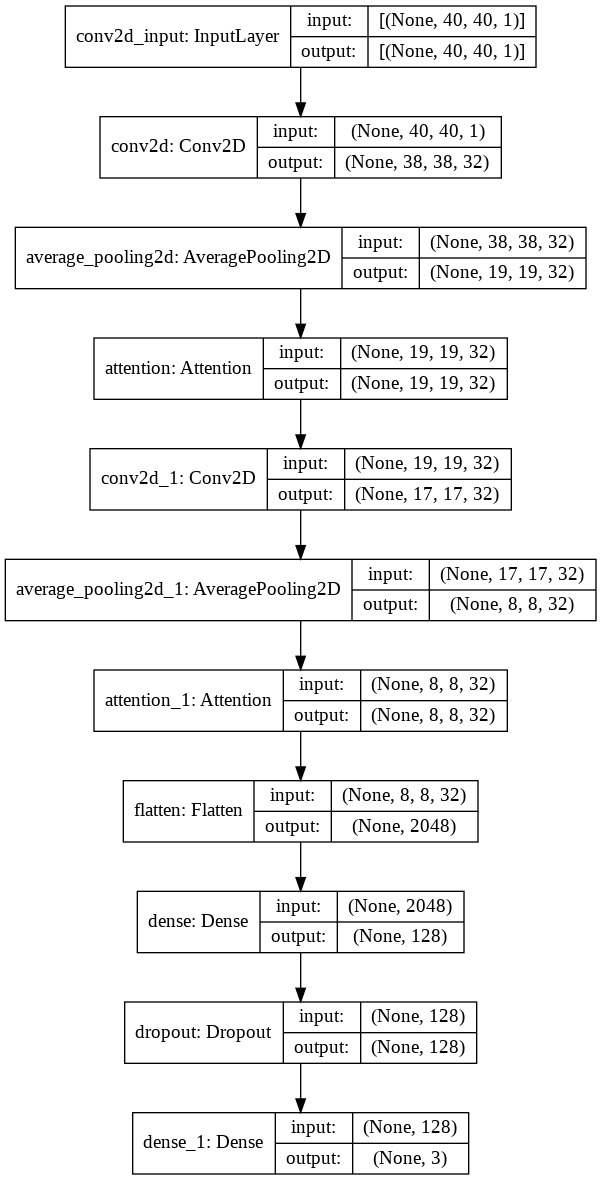

In [15]:
plot_model(model, "image/CNN_model.png", show_shapes=True)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [callback1, callback2]
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test,y_test), callbacks=callbacks, verbose=0)

### Evaluation

In [17]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.7167


[0.6881559491157532, 0.7166666388511658]

### Plotting

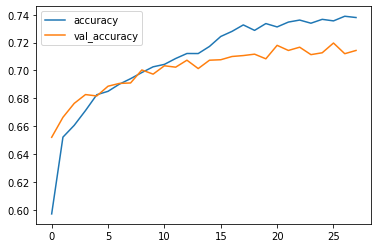

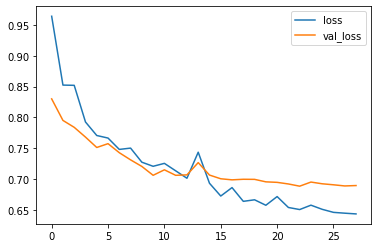

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

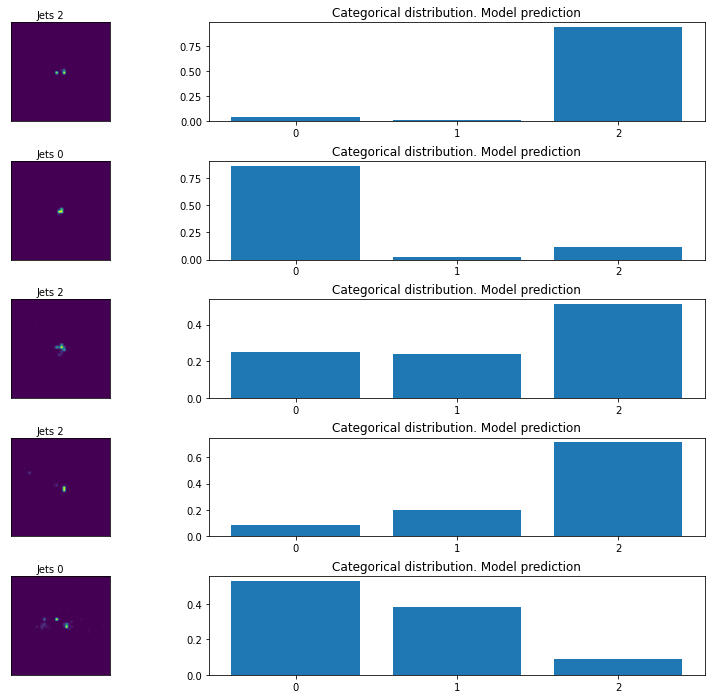

In [21]:
index = np.random.choice(X_test.shape[0], 5)
test_images = X_test[index, ...]
test_labels = [np.argmax(encoder) for encoder in y_test[index, ...]]

predictions = model.predict(test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, test_images, test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10.0, -2.0, f'Jets {label}')
    axes[i, 1].bar(np.arange(3), prediction)
    axes[i, 1].set_xticks(np.arange(3))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()